In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import patsy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

%matplotlib inline

sns.set_style("white")


# Psychophysik - Wahrnehmungsexperiment

#### aus:

Link functions

[Tom Wallis](http://www.tomwallis.info) and [Philipp Berens](http://philippberens.wordpress.com/)

The University of Tübingen

## Beispiel Experiment
[(Wallis & Bex, 2012)](http://www.journalofvision.org/content/12/7/6). 

Drei Versuchspersonen sollen Störungen erkennen:
- Störung besteht aus helligkeitsgleichen grob gefilterten Strukturen
- Fixation auf Bildmitte
- Störung hat verschiedene Durchmesser
- Abstand der Störung zur Bildmitte variiert "Exzentrizität"
- Störung wird an vier möglichen Positionen gezeig: 4AFC

Das Beispiels-Bild enthält viele Störungen auf einmal; im Versuch wird jeweils nur *eine* gezeigt.


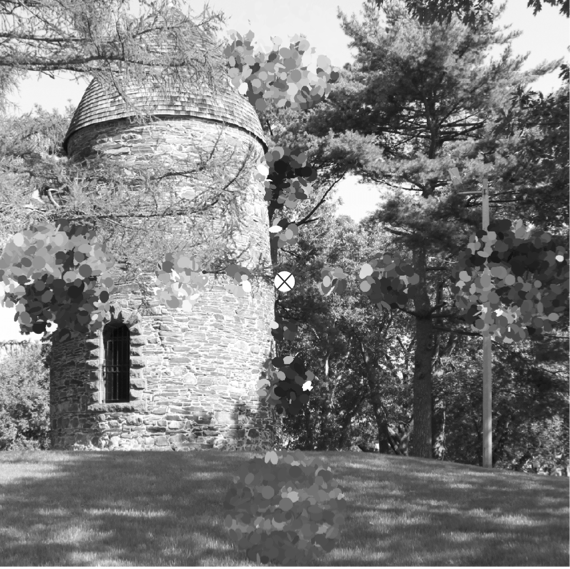

In [3]:
'''the data'''
nat_ims = pd.read_csv('data/psychophysics.txt', sep='\t')
nat_ims.columns = [c.lower() for c in nat_ims.columns]     # columns to lowercase
nat_ims.head()


,observer,trialnum,blocknum,eccent,patchsize,correct,targetloc,responseloc,imageori
0,TW,1.0,1.0,2.0,-0.391207,1.0,u,u,0CW
1,TW,2.0,1.0,2.0,-0.391207,1.0,d,d,270CW
2,TW,3.0,1.0,2.0,-0.505150,0.0,d,r,180CW
3,TW,4.0,1.0,2.0,-0.505150,1.0,l,l,270CW
4,TW,5.0,1.0,2.0,-0.505150,1.0,u,u,0CW


- Spalten:
    - Versuchspersonenkürzel, Versuchsnummer, innerhalb Versuchs-Block Nummer, Bildausrichtung
    - Exzentrizität in ° vom Fixationspunkt
    - Durchmesser der Störung in log 10 Pixel
    - Ort, an dem Störung gezeigt wurde & Antwort der Versuchsperson
    - **correct**, wenn richtig
- Zeilen
    - jeweils ein Versuch ~ Designmatrix

In [4]:
'''how many trials each subject?'''
nat_ims.groupby(['observer']).size()


observer
N1    17200
PB    16918
TW    16932
dtype: int64

In [5]:
'''select a small sub sample to save calculation time'''
np.random.seed(12345)                            # seed rng, random but reproducible
rows = np.random.choice(nat_ims.index, size=5000, replace=False)   # selection 
dat = nat_ims.ix[rows].copy()                    # data according to selection
dat.groupby(['observer', 'eccent']).size()


observer  eccent
N1        2.0       558
          4.0       597
          8.0       510
PB        2.0       527
          4.0       547
          8.0       571
TW        2.0       538
          4.0       570
          8.0       582
dtype: int64

### Daten und Modell
- abhängige Variable: Antworten 
    - Dichotom "richtig" / "falsch"
- unabhängige Variablen:
    - Exzentrizität
    - Größe *patch size*
    - Versuchsperson
- Generalisiertes Lineares Modell
    - Binomialverteilung
    - Logistische Linkfunktion *logit*
    - keine Beeinflussung (Interaktion) zwischen den unabhängigen Variablen

## Seaborn
Seaborn is a library for making attractive and informative statistical graphics in Python. 

- **Installation**
    - `conda install seaborn`
- **Verwendung**
    - `import seaborn as sns`
- **Links**
    - https://pypi.python.org/pypi/seaborn  
- **Lizenz**
    - BSD (3-clause)
- **Nebeneffekt**
    - Auswirkungen auf `matplotlib`-Layout

In [6]:
help(sns.lmplot)


Help on function lmplot in module seaborn.linearmodels:

lmplot(x, y, data, hue=None, col=None, row=None, palette=None, col_wrap=None, size=5, aspect=1, markers='o', sharex=True, sharey=True, hue_order=None, col_order=None, row_order=None, legend=True, legend_out=True, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=False, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None)
    Plot data and regression model fits across a FacetGrid.
    
    This function combines :func:`regplot` and :class:`FacetGrid`. It is
    intended as a convenient interface to fit regression models across
    conditional subsets of a dataset.
    
    When thinking about how to assign variables to different facets, a general
    rule is that it makes sense to use ``hue`` for the most important
    comparison, followed by ``col`` and ``row``. Ho

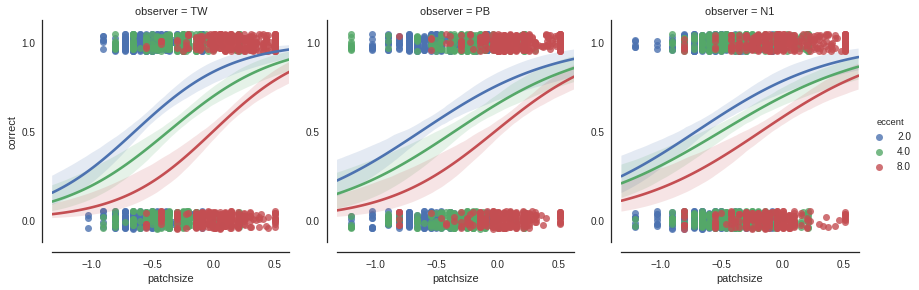

In [7]:
'''multi-dimensional binomial data: show together with logistic fit'''
g = sns.lmplot('patchsize', 'correct', data=dat,
           hue='eccent',
           col='observer',
           logistic=True, y_jitter=.05, size=4)
sns.despine(offset=10)
g.fig.subplots_adjust(wspace=0.2)
plt.yticks([0, 0.5, 1]);


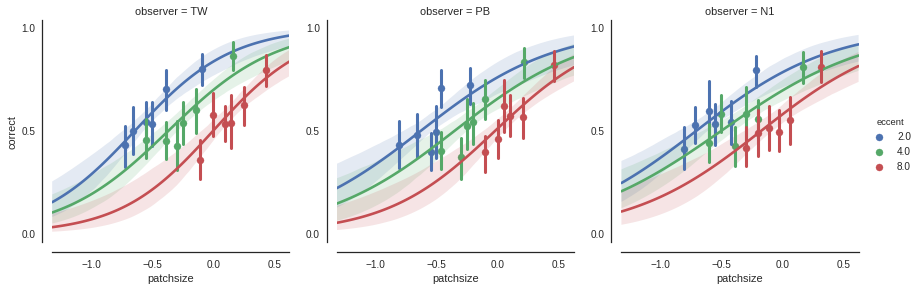

In [8]:
'''same, but data as expectation of pi'''
g = sns.lmplot('patchsize', 'correct', data=dat,
               hue='eccent',
               col='observer',
               logistic=True, x_bins=6, size=4)
sns.despine(offset=10)
g.fig.subplots_adjust(wspace=0.2)
plt.yticks([0, 0.5, 1]);


In [9]:
fit = smf.glm('correct ~ patchsize + C(eccent)', 
              data=nat_ims, 
              family=sm.families.Binomial(link=sm.families.links.logit)).fit()
print(fit.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                correct   No. Observations:                51050
Model:                            GLM   Df Residuals:                    51046
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -33392.
Date:                Tue, 02 May 2017   Deviance:                       66784.
Time:                        16:41:29   Pearson chi2:                 5.10e+04
No. Iterations:                     5                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2857      0.025     51.341      0.000       1.237       1.335
C(eccent)[T.4.0]    -0.5116      0

In [10]:
'''the logit link function'''
def logit(x):
    return np.exp(x)/ (1+np.exp(x))


In [11]:
'''meaning of parameters a) eccentricity'''
paramlist = ['Intercept', 'C(eccent)[T.4.0]', 'C(eccent)[T.8.0]']
exc = [fit.params[p] for p in paramlist]   # read parameters for categorie's intercepts
exc[1:] += exc[0]                          # all except first share common "intercept"

for e, p in zip(exc, paramlist):
    pc = logit(e)                          # percent correct with changing eccentricity
    print('eccentricity {:16s} would have a linear predictor of {:5.3f} or {:4.1f}% correct'
          .format(p, e, 100*pc))
    

eccentricity Intercept        would have a linear predictor of 1.286 or 78.3% correct
eccentricity C(eccent)[T.4.0] would have a linear predictor of 0.774 or 68.4% correct
eccentricity C(eccent)[T.8.0] would have a linear predictor of 0.077 or 51.9% correct


In [12]:
'''meaning of parameters b) patch size'''
psize = np.asarray([-1, 0, 1])
for pi in psize:                            # percent correct with changing patch size
    print('patchsize {:4.1f} would have {:4.1f} %-correct'
          .format(pi, 100*logit(exc[0] + pi*fit.params[3])))
    

patchsize -1.0 would have 32.4 %-correct
patchsize  0.0 would have 78.3 %-correct
patchsize  1.0 would have 96.5 %-correct


## Ergebnis
#### Einfluß der Stimulusgröße
                           coef    std err          z      P>|z|      [0.025      0.975]
    ------------------------------------------------------------------------------------
    Intercept            1.2857      0.025     51.341      0.000       1.237       1.335
    patchsize            2.0228      0.036     55.684      0.000       1.952       2.094

Je größer ein Stimulus (bei gleicher Exzentrizität), desto besser wird er erkannt <br>
Je-desto ist nicht linear sondern vermittels Link-Funktion `logit`:

    patchsize -1.0 would have 32.4 %-correct
    patchsize  0.0 would have 78.3 %-correct
    patchsize  1.0 would have 96.5 %-correct

#### Einfluß der Exzentrizizät
                           coef    std err          z      P>|z|      [0.025      0.975]
    ------------------------------------------------------------------------------------
    Intercept            1.2857      0.025     51.341      0.000       1.237       1.335
    C(eccent)[T.4.0]    -0.5116      0.024    -21.134      0.000      -0.559      -0.464
    C(eccent)[T.8.0]    -1.2084      0.031    -39.076      0.000      -1.269      -1.148

Je weiter in der Peripherie ein Stimulus (gleicher Größe) gezeigt wird, desto schlechter wird er erkannt. <br>
Je-desto ist nicht linear sondern vermittels Link-Funktion `logit`:

    eccentricity Intercept        would have a linear predictor of 1.286 or 78.3% correct
    eccentricity C(eccent)[T.4.0] would have a linear predictor of 0.774 or 68.4% correct
    eccentricity C(eccent)[T.8.0] would have a linear predictor of 0.077 or 51.9% correct


# Zusammenfassung
Dichotome Daten können mit GLM modelliert werden
- Binomial-Verteilung
- Logistische Link-Funktion: **Generalisiertes** Lineares Modell
    - auch andere: Probit, komplementäre-Log-Log, ...
- Lineares Modell erlaubt Einfluß von unabhängigen Variablen (*predictors*) 
    - hier Exzentrizität, Stimulus-Größe, Individualität (Versuchsperson)

### Anwendung
- Psychologische Experimente, Neurowissenschaften

### Inferenz
- Wahrnehmungsschwelle
- Informationsverarbeitung